<a href="https://colab.research.google.com/github/wnubhav/Spambase-Clustering/blob/main/clustering_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
spambase = fetch_ucirepo(id=94)

# data (as pandas dataframes)
X = spambase.data.features
y = spambase.data.targets

# metadata
print(spambase.metadata)

# variable information
print(spambase.variables)


{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [2]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

spambase = fetch_ucirepo(id=94)
X = spambase.data.features.values

def initialize_centroids(X, k):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def compute_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def kmeans(X, k, max_iter=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iter):
        labels = assign_clusters(X, centroids)
        new_centroids = compute_centroids(X, labels, k)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels, centroids


In [3]:
from scipy.spatial.distance import cdist

def single_linkage(clusters):
    k = len(clusters)
    distances = {}
    for i in range(k):
        for j in range(i+1, k):
            dist = np.min(cdist(clusters[i], clusters[j]))
            distances[(i, j)] = dist
            distances[(j, i)] = dist
    return distances

def sorted_cluster_neighbors(distances, k):
    neighbor_list = {}
    for i in range(k):
        dists = [(j, distances[(i, j)]) for j in range(k) if j != i]
        dists.sort(key=lambda x: x[1])
        neighbor_list[i] = [j for j, _ in dists]
    return neighbor_list


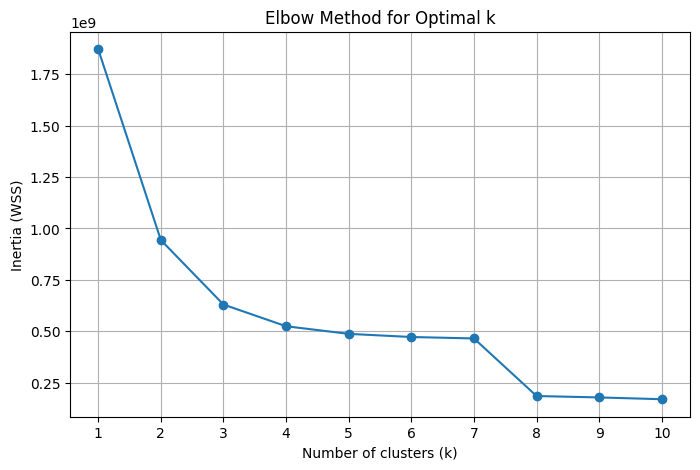

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

def calculate_inertia(X, k_range):
    inertias = []
    for k in k_range:
        labels, centroids = kmeans(X, k)
        closest, distances = pairwise_distances_argmin_min(X, centroids)
        inertia = np.sum(distances ** 2)
        inertias.append(inertia)
    return inertias

k_range = range(1, 11)
inertias = calculate_inertia(X, k_range)


plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [5]:
k = 2
labels, centroids = kmeans(X, k)


clusters = [X[labels == i] for i in range(k)]


distances = single_linkage(clusters)

print("\nSingle-linkage distances between clusters:")
for (i, j), dist in distances.items():
    if i < j:
        print(f"Distance between Cluster C{i} and Cluster C{j}: {dist:.4f}")

neighbors = sorted_cluster_neighbors(distances, k)


for i in range(k):
    print(f"Cluster C{i}: closest clusters by single-linkage -> {['C'+str(j) for j in neighbors[i]]}")






Single-linkage distances between clusters:
Distance between Cluster C0 and Cluster C1: 18.4287
Cluster C0: closest clusters by single-linkage -> ['C1']
Cluster C1: closest clusters by single-linkage -> ['C0']


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


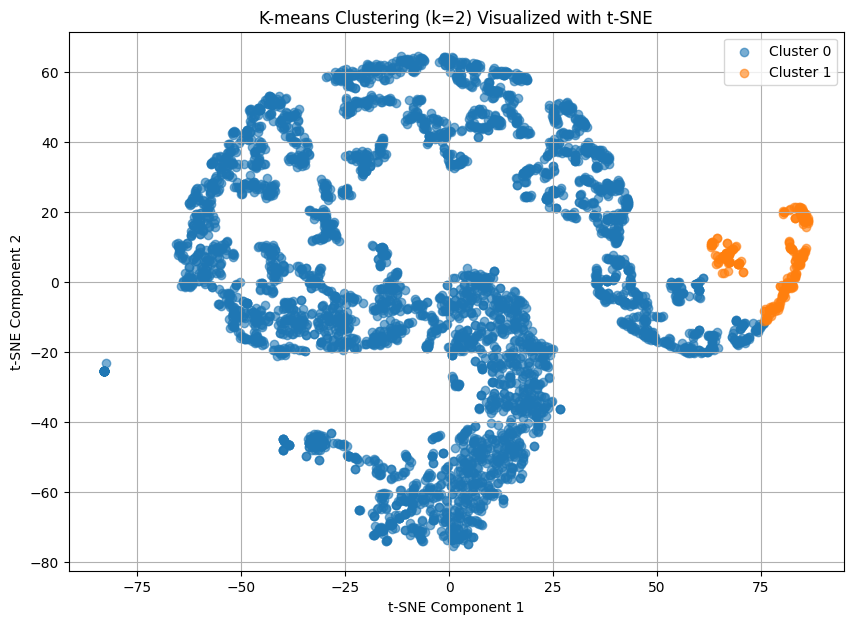

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)


plt.figure(figsize=(10, 7))
for i in range(2):
    plt.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1],
                label=f'Cluster {i}', alpha=0.6)

plt.title('K-means Clustering (k=2) Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()
